# Visualising Simplicial Laplacian 1-Eigenvectors

In this notebook, we develop a few examples of using de rham networks to visualise the 1-eigenvectors of the simplicial laplacian.

In [8]:
import numpy as np
import matplotlib as mpl
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

from sklearn.datasets import make_circles
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd

# for building the boundary matrices
from scipy import sparse
from scipy.sparse import coo_matrix,diags

import neural_kforms as nkf

We begin by initialising a small point cloud in 2D.

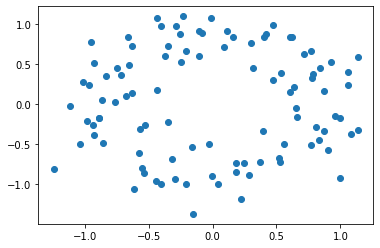

In [10]:
# Initialise some noisey circles
data =  make_circles(n_samples=100, shuffle=True, noise=0.2, random_state=None, factor=0.8)[0]
plt.scatter(data[:,0], data[:,1])
plt.show()

We then use Ripser to work out a good filtration index where there is a non-trivial cohomology class.

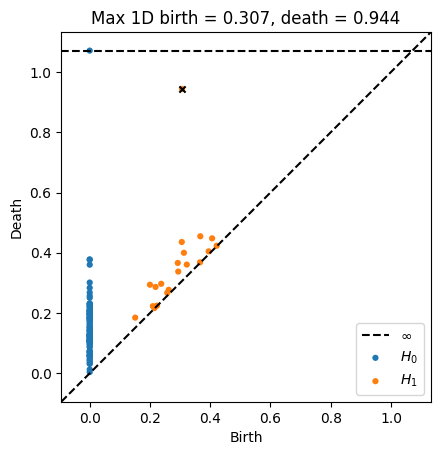

In [12]:
# find a good threshold for the data 
result = ripser(data, coeff=3, do_cocycles=True, maxdim =1)
diagrams = result['dgms']
cocycles = result['cocycles']
dgm1 = diagrams[1]

# identify the index of the longest interval
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])

# store the corresponding cocycle
cocycle = cocycles[1][idx]

# plot diagram with longest interval highlighted
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

We make a small illustration of the Cech cover of the point cloud at the given filtration index.

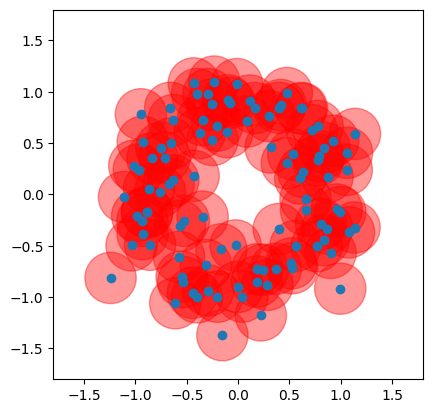

In [14]:

for i in range(len(data)):
    plt.gca().add_artist(plt.Circle(data[i], 0.5/2, color='r', fill=True, alpha = 0.4))

# plot a ball of radius 0.5 around each point in data
plt.scatter(data[:,0], data[:,1])

# make the plot square
plt.axis('square')

# set the limits of the plot
plt.xlim([-1.8, 1.8])
plt.ylim([-1.8, 1.8])

# save the plot
plt.savefig('./figures/1-eigenvectors/rips.png', dpi=300)

plt.show()


Now we construct the simplicial Laplacian of the Rips complex, and compute the first 10 eigenvectors

In [31]:
# build a simplex tree
Rips_complex_sample = gd.RipsComplex(points = data, max_edge_length=0.5)
st = Rips_complex_sample.create_simplex_tree(max_dimension=2)

# extract simplices
simplices = nkf.extract_simplices(st)

# build the boundary matrices and laplacian
boundaries = nkf.build_boundaries(simplices)
laplacian = boundaries[0].T @ boundaries[0] + boundaries[1] @ boundaries[1].T
laplacian = np.array(laplacian.todense())

# only calculate the first 10 eigenvectors of the laplacian corresponding to the first 10 eigenvalues without calculating the full set of eigenvectors
eigvals, eigvecs = sparse.linalg.eigsh(laplacian, k=10, which='SM')

# turn eigvecs into a torch tensor
eigvecs = torch.tensor(eigvecs)

## Representing the simplicial complex as a chain

In [32]:
# extract simpices
simplices = nkf.extract_simplices(st)
one_simplices = [np.sort(list(elem)) for elem in simplices[1].keys()]
chain = nkf.one_skeleton_to_chain(one_simplices, data)

## Learning Vector Fields in $\mathbb{R}^2$ which Correspond to the Eigenvectors of the Laplacian

In [33]:
c = 10 # number of features/columns in cochain data matrix (corresponds to 10 eigenvectors)

vf = nn.Sequential(
    nn.Linear(2, 50),
    nn.ReLU(),
    nn.Linear(50, 30),
    nn.ReLU(),
    nn.Linear(30, 2*c)
)

### Do the Training

In [34]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(vf.parameters(), lr=1e-2)


In [46]:
epoch = 1000

for i in range(epoch):

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers

    # calculate the integration matrix
    X = nkf.gen_CDM(vf,chain)

    # calculate the difference between the CDM and the eigenvectors
    diff = X - eigvecs

    # L_2 Read-out layer
    L = torch.sum(torch.diag(diff @ diff.T))

    # backpropagate
    L.backward()
    optimizer.step()    # Does the update

    # print the loss every 10 iterations
    if i % 10 == 0:
        print("Iteration: ", i, "Loss: ", L)

Iteration:  0 Loss:  tensor(3.9767, grad_fn=<SumBackward0>)
Iteration:  10 Loss:  tensor(3.9566, grad_fn=<SumBackward0>)
Iteration:  20 Loss:  tensor(3.9367, grad_fn=<SumBackward0>)
Iteration:  30 Loss:  tensor(3.9171, grad_fn=<SumBackward0>)
Iteration:  40 Loss:  tensor(3.8976, grad_fn=<SumBackward0>)
Iteration:  50 Loss:  tensor(3.8781, grad_fn=<SumBackward0>)
Iteration:  60 Loss:  tensor(3.8588, grad_fn=<SumBackward0>)
Iteration:  70 Loss:  tensor(3.8397, grad_fn=<SumBackward0>)
Iteration:  80 Loss:  tensor(3.8208, grad_fn=<SumBackward0>)
Iteration:  90 Loss:  tensor(3.8021, grad_fn=<SumBackward0>)
Iteration:  100 Loss:  tensor(3.7838, grad_fn=<SumBackward0>)
Iteration:  110 Loss:  tensor(3.7656, grad_fn=<SumBackward0>)
Iteration:  120 Loss:  tensor(3.7476, grad_fn=<SumBackward0>)
Iteration:  130 Loss:  tensor(3.7297, grad_fn=<SumBackward0>)
Iteration:  140 Loss:  tensor(3.7120, grad_fn=<SumBackward0>)
Iteration:  150 Loss:  tensor(3.6946, grad_fn=<SumBackward0>)
Iteration:  160 Los

/var/folders/hz/4pywr0zn1y34rhzrg6_ntgs80000gq/T/ipykernel_93847/3950755924.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, i+1)


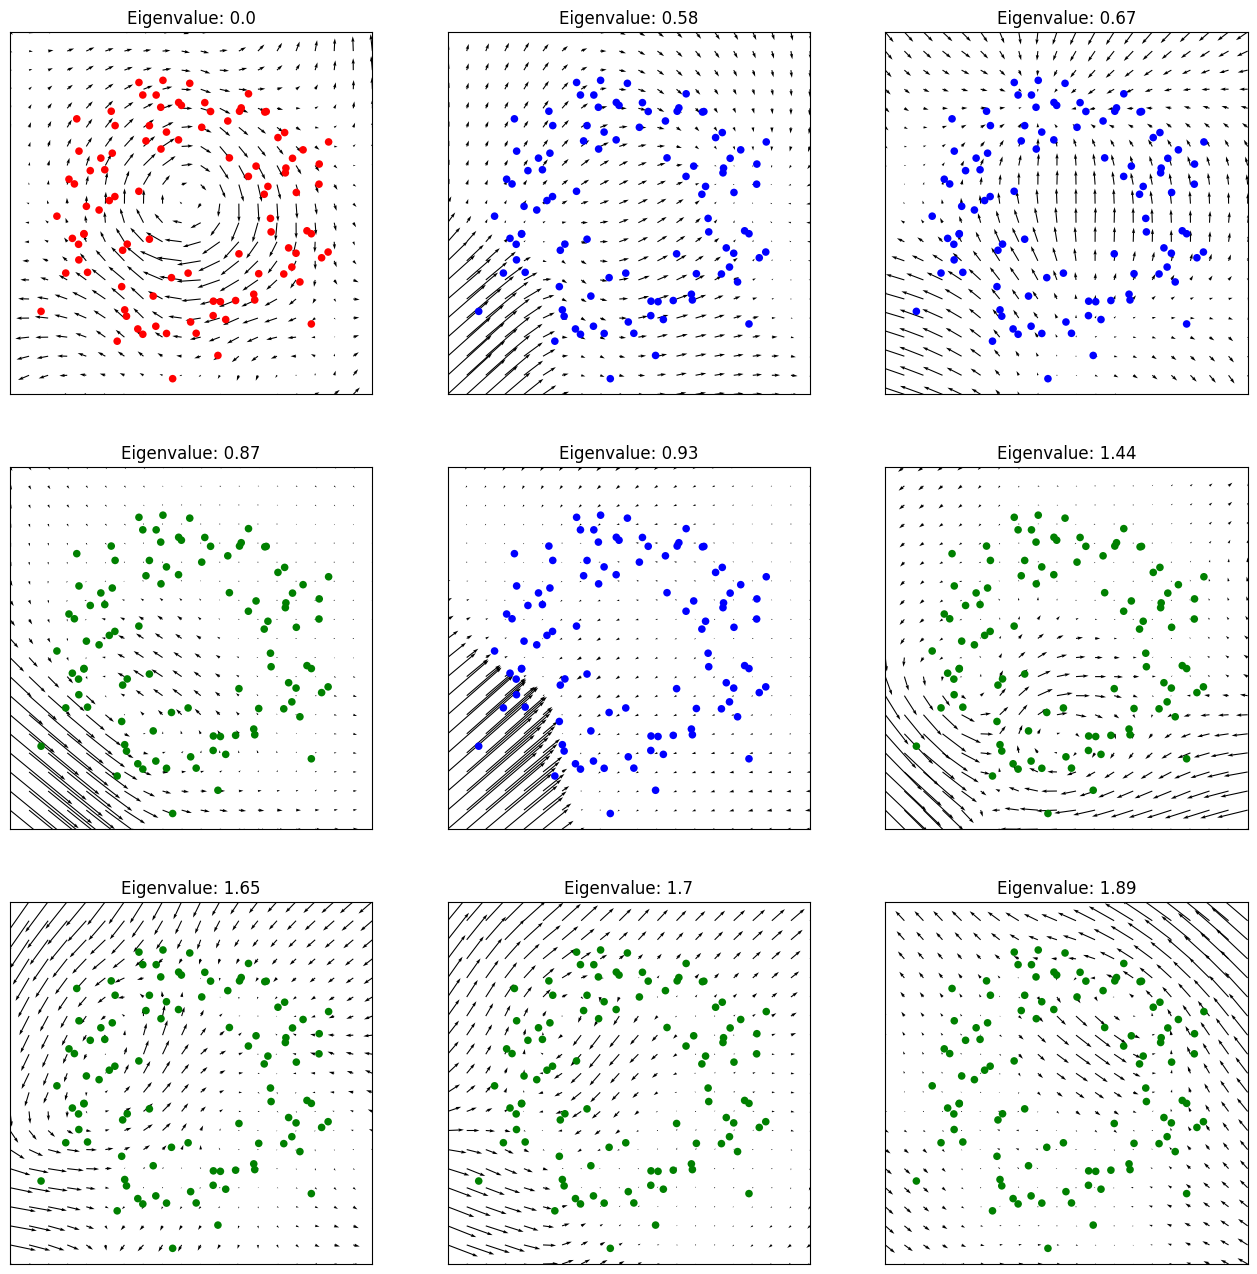

In [47]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    nkf.plot_component_vf(vf, ax, comp = i, x_range=1.5, y_range=1.5)


    # overlot the point cloud onto each subplot

    if i in [0]:
        ax.scatter(data[:,0], data[:,1], s=30, c='red', alpha=1, marker='o', edgecolors='none')
    elif i in [1,2,4]:   
        ax.scatter(data[:,0], data[:,1], s=30, c='blue', alpha=1, marker='o', edgecolors='none')
    else:
        ax.scatter(data[:,0], data[:,1], s=30, c='green', alpha=1, marker='o', edgecolors='none')
    
    # make the points a bit bigger
    


    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # add a title to each subplot with i-th eigenvalue (up to 2 decimal places) corresponding to the i-th subplot 
    ax.set_title('Eigenvalue: ' + str(np.round(eigvals[i],2)))
    

# make the figure a bit bigger
fig.set_size_inches(16,16)


# save teh figure
plt.savefig('./figures/1-eigenvectors/learned-vf.png', dpi=300)


plt.show()